# Прогнозирование оттока клиентов фитнес-клуба

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов.

Наша задача — провести анализ и подготовить план действий по удержанию клиентов:

* научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
* сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
* проанализировать основные признаки, наиболее сильно влияющие на отток;
* сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
    1. выделить целевые группы клиентов;
    2. предложить меры по снижению оттока;
    3. определить другие особенности взаимодействия с клиентами.

<a id='content'></a>
## Оглавление

### Исследовательский анализ данных (EDA)  
* [Посмотрим на датасет: есть ли в нем отсутствующие признаки, изучим средние значения и стандартные отклонения](#part_0.1)
* [Рассмотрим средние показатели для двух групп - тех, кто ушел в отток и тех, кто остался](#part_0.2)
* [Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)](#part_0.3)
* [Построим матрицу корреляций](#part_0.4)

### Модель прогнозирования оттока клиентов
* [Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце](#part_1.0)
* [Логистическая регрессия](#part_1.1)
* [Случайный лес](#part_1.2)
* [Вывод](#part_1.3)

### Кластеризация клиентов
* [Стандартизируем данные](#part_2.1)
* [Построим дендрограмму](#part_2.2)
* [Алгоритм K-Means](#part_2.3)
* [Распределения признаков по кластерам](#part_2.4)


### Вывод
* [Сделаем общий вывод](#finish)

# Исследовательский анализ данных (EDA) 
<a id='part_0.1'></a>
Посмотрим на датасет: есть ли в нем отсутствующие признаки, изучим средние значения и стандартные отклонения

[*Назад к оглавлению*](#content)

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans

In [2]:
data = pd.read_csv('/datasets/gym_churn.csv')

In [3]:
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


Можем заметить, что пропусков в данных нет.

In [5]:
data.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f24ef2842d0>,
      dtype=object)

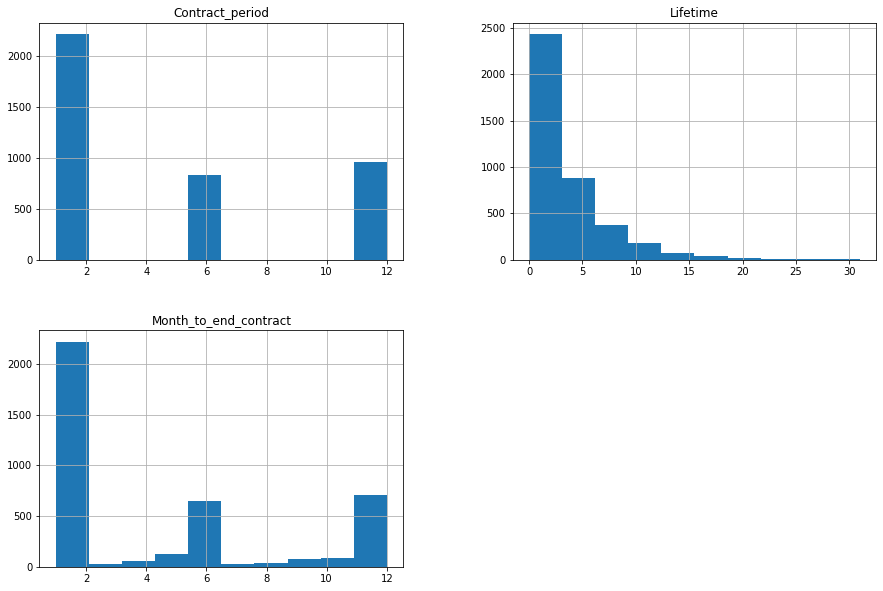

In [6]:
data[['Contract_period', 'Month_to_end_contract', 'Lifetime']].hist(figsize=(15,10))

Пока мы можем сделать следующие выводы:
* по полу выборка достаточно равномерная: мужчины и женщины распределились почти в равных долях
* большинство (85%) клиентов живут или работают в локаци, где находится фитнес-клуб
* около половины клиентов - сотрудники компаний-партнеров клуба
* около 31% клиентов привели их друзья
* большинство клиентов (90%) оставили свой номер телефона
* 41% клиентов посещают групповые занятия
* средний и медианный возраст - 29 лет, стандартное отклонение всего 3,25 - так что разброс возраста не очень большой.
* в среднем клиенты тратят на другие услуги клуба около 150, однако стандартное отклонение состоявляет почти 100 - это очень большое разброс в данных. Кто-то из клиентов потратил более 550
* Больше половины клиентов заключили контракт на 1 месяц, остальные и по четверти клиентов контракты на 6 и 12 месяцев
* Также можно заметить, что у большинства клиентов до конца контрактв остались 1, 5-6 или 11-12 месяцев. Значит в основная часть клиентов совсем недавно заключали свои контракты.
* Это подтверждает и среднее время с момента первого обращения в фитнес-центр - для большинства клиентов это срок до 5 месяцев.
* Отток составляет около 26,5%.

<a id='part_0.2'></a>
Рассмотрим средние показатели для двух групп - тех, кто ушел в отток и тех, кто остался.

In [7]:
data.groupby('Churn').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


На этом этапе ясно, что:
* Мужчины и женщины уходят в отток одинакого - структура практически не поменялась
* Те, кто остаются в клубе, в основном живут в локации клуба (87%). Среди тех, кто уходит в отток таких всего 77%.
* Большая часть тех, кто остается в клубе являются сотрудниками компаний-партнеров. Из тех, кто ушел в отток, таких только 35%.
* Продолжающие занимаьться куда чаще ходят на групповые тренировки - 46% против 27%.

<a id='part_0.3'></a>
Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

Text(0.5, 1.0, 'средняя частота посещений в неделю за предыдущий месяц')

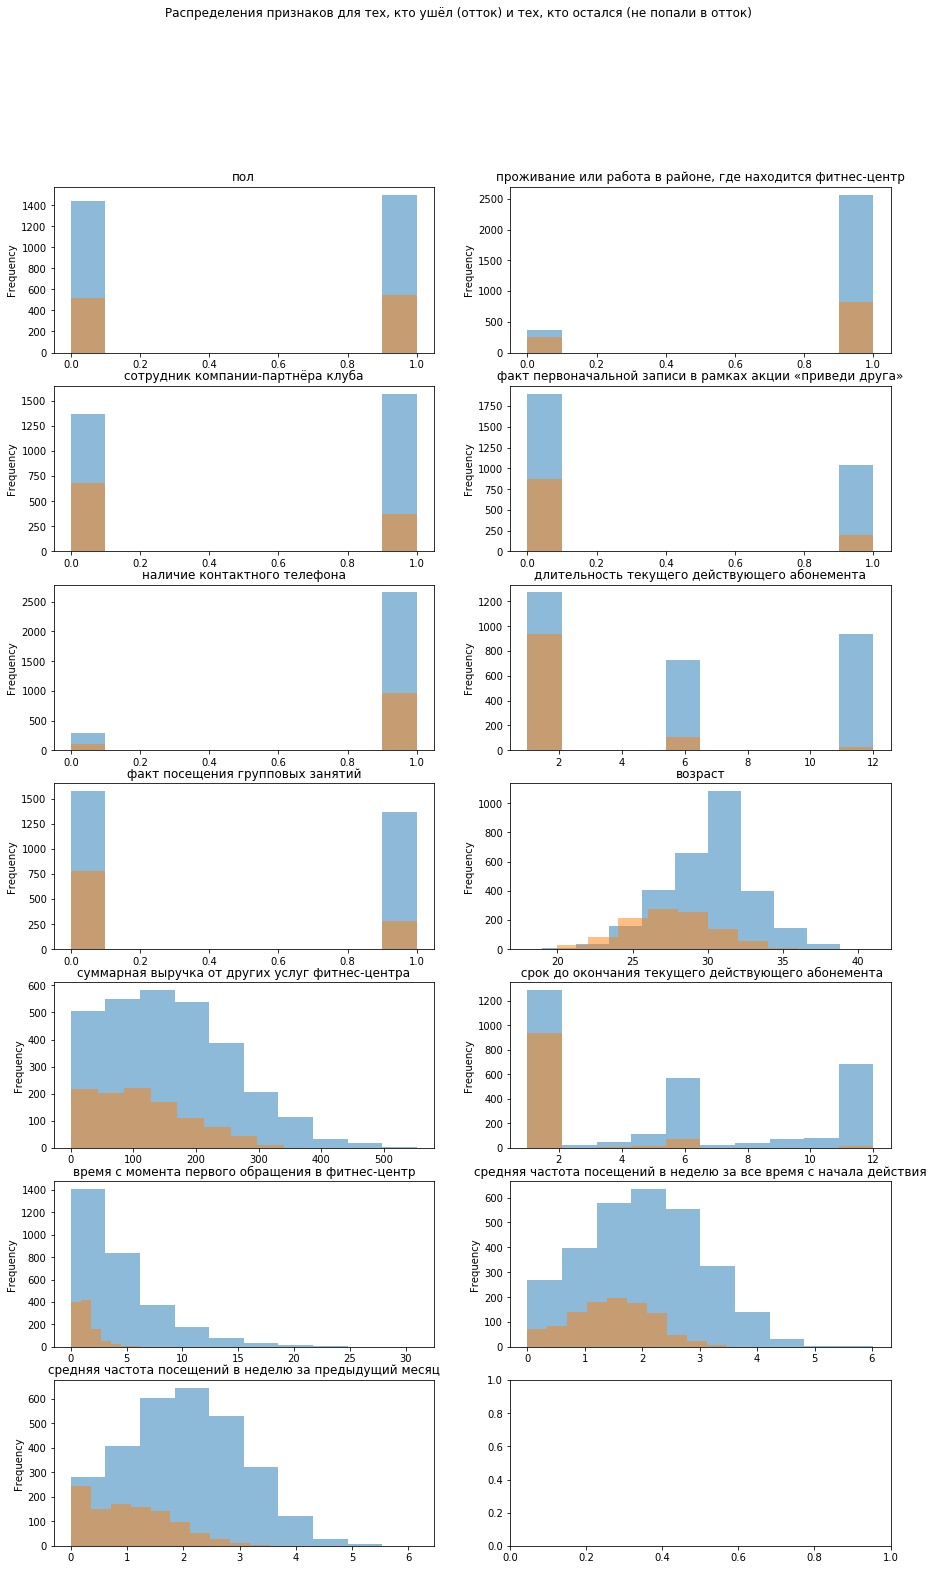

In [8]:
fig, axs = plt.subplots(7,2)
fig.suptitle('Распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)')
fig.set_figheight(25)
fig.set_figwidth(15)
data.groupby('Churn')['gender'].plot.hist(ax=axs[0][0], alpha=0.5)
axs[0][0].set_title('пол')
data.groupby('Churn')['Near_Location'].plot.hist(ax=axs[0][1], alpha=0.5)
axs[0][1].set_title('проживание или работа в районе, где находится фитнес-центр')
data.groupby('Churn')['Partner'].plot.hist(ax=axs[1][0], alpha=0.5)
axs[1][0].set_title('сотрудник компании-партнёра клуба')
data.groupby('Churn')['Promo_friends'].plot.hist(ax=axs[1][1], alpha=0.5)
axs[1][1].set_title('факт первоначальной записи в рамках акции «приведи друга»')
data.groupby('Churn')['Phone'].plot.hist(ax=axs[2][0], alpha=0.5)
axs[2][0].set_title('наличие контактного телефона')
data.groupby('Churn')['Contract_period'].plot.hist(ax=axs[2][1], alpha=0.5)
axs[2][1].set_title('длительность текущего действующего абонемента')
data.groupby('Churn')['Group_visits'].plot.hist(ax=axs[3][0], alpha=0.5)
axs[3][0].set_title('факт посещения групповых занятий')
data.groupby('Churn')['Age'].plot.hist(ax=axs[3][1], alpha=0.5)
axs[3][1].set_title('возраст')
data.groupby('Churn')['Avg_additional_charges_total'].plot.hist(ax=axs[4][0], alpha=0.5)
axs[4][0].set_title('суммарная выручка от других услуг фитнес-центра')
data.groupby('Churn')['Month_to_end_contract'].plot.hist(ax=axs[4][1], alpha=0.5)
axs[4][1].set_title(' срок до окончания текущего действующего абонемента')
data.groupby('Churn')['Lifetime'].plot.hist(ax=axs[5][0], alpha=0.5)
axs[5][0].set_title('время с момента первого обращения в фитнес-центр')
data.groupby('Churn')['Avg_class_frequency_total'].plot.hist(ax=axs[5][1], alpha=0.5)
axs[5][1].set_title('средняя частота посещений в неделю за все время с начала действия')
data.groupby('Churn')['Avg_class_frequency_current_month'].plot.hist(ax=axs[6][0], alpha=0.5)
axs[6][0].set_title('средняя частота посещений в неделю за предыдущий месяц')

* Средний возраст оставшихся в фитнес-центре и оттока отличается не так сильно - 30 лет против 27.
* Можно заметить, что среди тех, кто не ходил на групповые тренировки крайне мало клиентов, которые в дальнейшем продолжили заниматься в клубе. Возможно, они зря не ходили?
* покупками в клучбе занимались примерно одинаково, вряд ли это сильно влияет на отток.
* Подавляющее число клиентов попавших в отток брали контракт всего на один месяц, видимо. попробовали и им не понравилось. По продолжающим заниматься ситуация намного лучше, контрактов на 1 месяц все-таки большинство, но 12 месяцев не сильно отстают. Да и желающих заниматься полгода достаточно.
* Сильно отличаются сроки до конца контракта (что логично, так как и сама длительность контрактов отличается).
* Зато можно заметить, что в основном уходят люди слегка не доходя первый месяц. Те, кто остаются, в среднем имеют более длительные отношения с фитнес-центром - около 4,7 месяцев.
* Частота посещения клуба за все время примерно похожа для тех, кто уходит, и тех, кто остается (хотя в среднем те, кто остаются заниматься все же ходят почаще).
* А вот ситуация в последний месяц резко отличается: те, кто планирует уходить, почти не посещают клуб.

<a id='part_0.4'></a>
Построим матрицу корреляций.

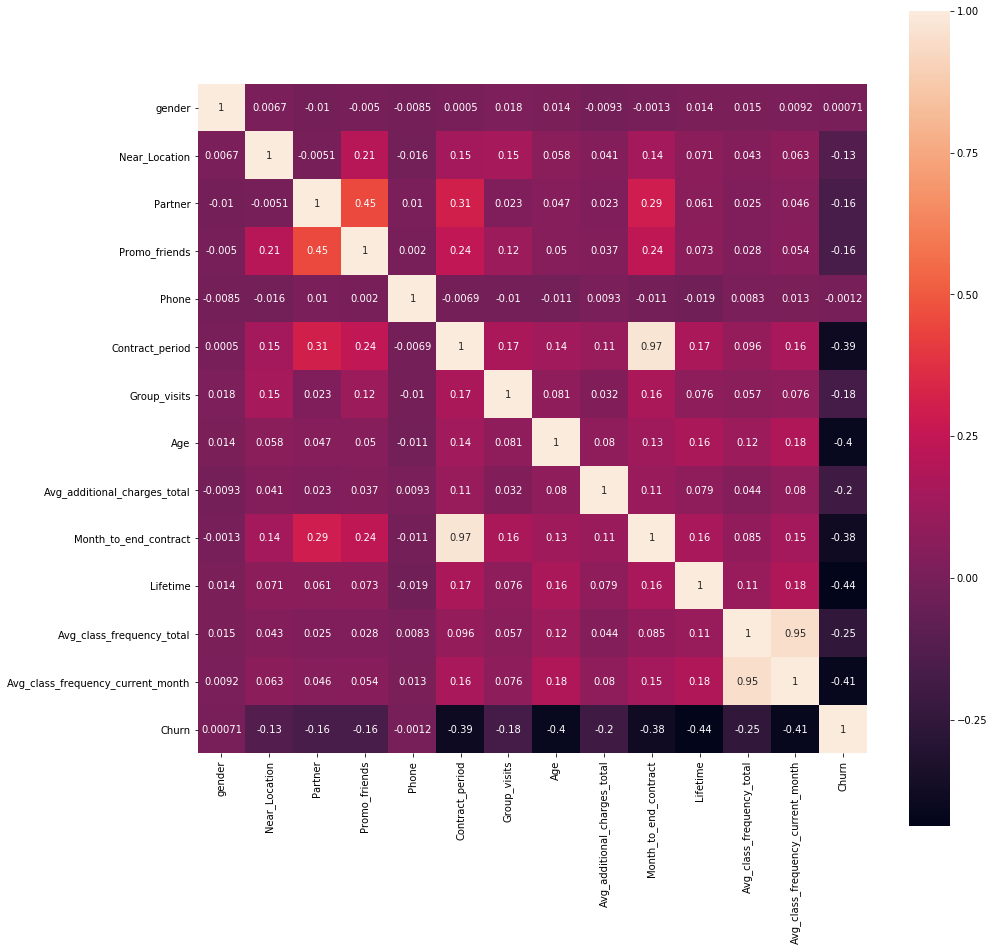

In [9]:
plt.figure(figsize=(15, 15)) 
sns.heatmap(data.corr(), annot = True, square=True)

Сразу можно заметить несклько пар признаков, имеющих наибольшую корреляцию между собой:
1. Длина контракта и Число месяцев до конца контракта
2. Частота посещений фитнес центра за все время и за последний месяц.

Также достаточно сильно между собой коррелируют акция "приведи друга" и клиенты-сотрудники компаний-партнеров.

С целевой переменной (отток) достаточно сильную обратную корреляцию имеют следующие признаки:
* длина контракта
* возраст
* период до конца контракта
* длительность отношений с клубом
* частота почсещения клуба в последний месяц.

# Модель прогнозирования оттока клиентов

[*Назад к оглавлению*](#content)

<a id='part_1.0'></a>
Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце

In [10]:
X = data.drop(columns=['Churn'])
y = data['Churn']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify = y)

In [12]:
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))

<a id='part_1.1'></a>
Логистическая регрессия.

In [13]:
model_lr = LogisticRegression(solver='liblinear')
model_lr.fit(X_train, y_train)
predictions_lr = model_lr.predict(X_test)
probabilities_lr = model_lr.predict_proba(X_test)[:,1]

In [14]:
print_all_metrics(
    y_test,
    predictions_lr,
    probabilities_lr,
    title='Метрики для модели логистической регрессии:',
)

Метрики для модели логистической регрессии:
	Accuracy: 0.93
	Precision: 0.89
	Recall: 0.84
	F1: 0.87


<a id='part_1.2'></a>
Случайный лес.

In [15]:
model_rf = RandomForestClassifier(n_estimators = 100, random_state = 0)
model_rf.fit(X_train, y_train)
predictions_rf = model_rf.predict(X_test)
probabilities_rf = model_rf.predict_proba(X_test)[:,1]

In [16]:
print_all_metrics(
    y_test,
    predictions_rf,
    probabilities_rf,
    title='Метрики для модели случайного леса:',
)

Метрики для модели случайного леса:
	Accuracy: 0.92
	Precision: 0.88
	Recall: 0.83
	F1: 0.85


<a id='part_1.3'></a>

По результатам проверки метрик можно заметить, что логистическая регрессия на наших данных работает несколько лучше случайного леса.

# Кластеризация клиентов

[*Назад к оглавлению*](#content)

<a id='part_2.1'></a>
Стандартизируем данные.

In [17]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

<a id='part_2.2'></a>
Построим дендрограмму.

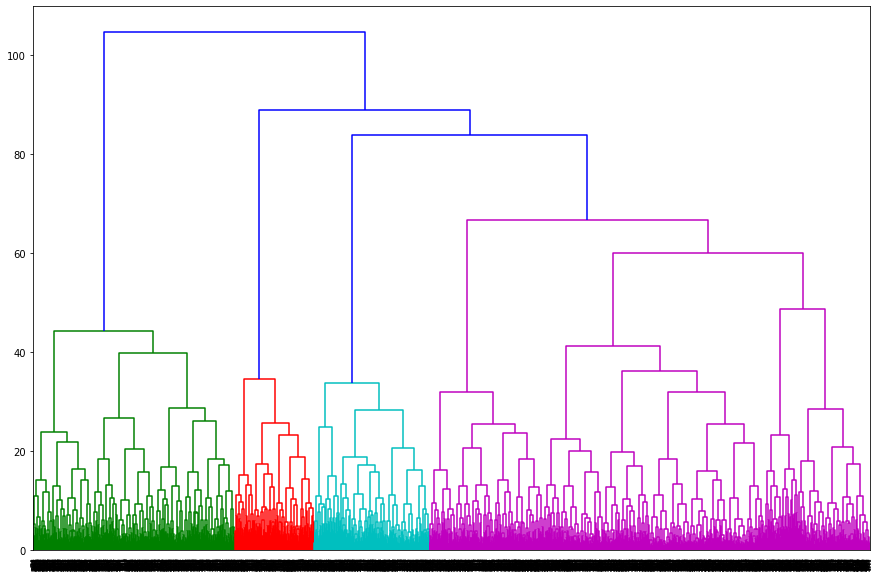

In [18]:
linked = linkage(X_sc, method = 'ward') 
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show() 

В целом можно разделить данные на разное число кластеров - от 4 до 6.

Далее будем рассматривать 5 кластеров.

<a id='part_2.3'></a>
Алгоритм K-Means.

In [19]:
km = KMeans(n_clusters = 5, random_state = 0)
labels = km.fit_predict(X_sc)
data['cluster'] = labels

In [20]:
data.groupby('cluster').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
cluster,,,,,,,,,,,,,,
0,0.502473,0.959446,0.783383,0.574679,1.000000,10.884273,0.543027,29.980218,160.706969,9.950544,4.738872,1.983305,1.976225,0.027695
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,0.560335,0.976105,0.356033,0.229391,0.998805,2.665472,0.473118,30.127838,161.724258,2.455197,4.896057,2.851531,2.849473,0.068100


По результатам кластеризации можем заметить следующее:
* Группа 0 самая надежная - у нее меньше всего процент отттока. Это объясняется стаблильностью клиентов - они работают в компании-партнере, их дом или работа находится близко к фитнес-центру, они заключают длительные договоры, лучше всех ходят на групповые занятия, тратят больше всего денег, часто ходят на тренировки (и в целом, и за последний месяц) и имеют длительные отношения с клубом.
* Следующей является группа 4. Они не является партнерами и не приходят по акции. Зато живут или работают рядом и очень любят заниматься (чаще остальных групп ходят на тренировки в целом и за последний месяц).
* Далее идут группа 1. Они уверенные среднячки - с значениями, очень похожими на общую картину по всей выборке.
* Наихудшими групами является группы 2 и 3. В группе 2 нет ни одного клиента, проживающего или работающего поблизости (возможно поэтому они и перестают ходить - долгая дорога до клуба никогда не вызывает желания позаниматься). В группе 3 наоборот все живут поблизости, но очень плохо ходят на тренировки (худший результат из всех групп). Возможно, фитнес-центр - это просто не для них.

<a id='part_2.4'></a>
Распределения признаков по кластерам.

Text(0.5, 1.0, 'отток')

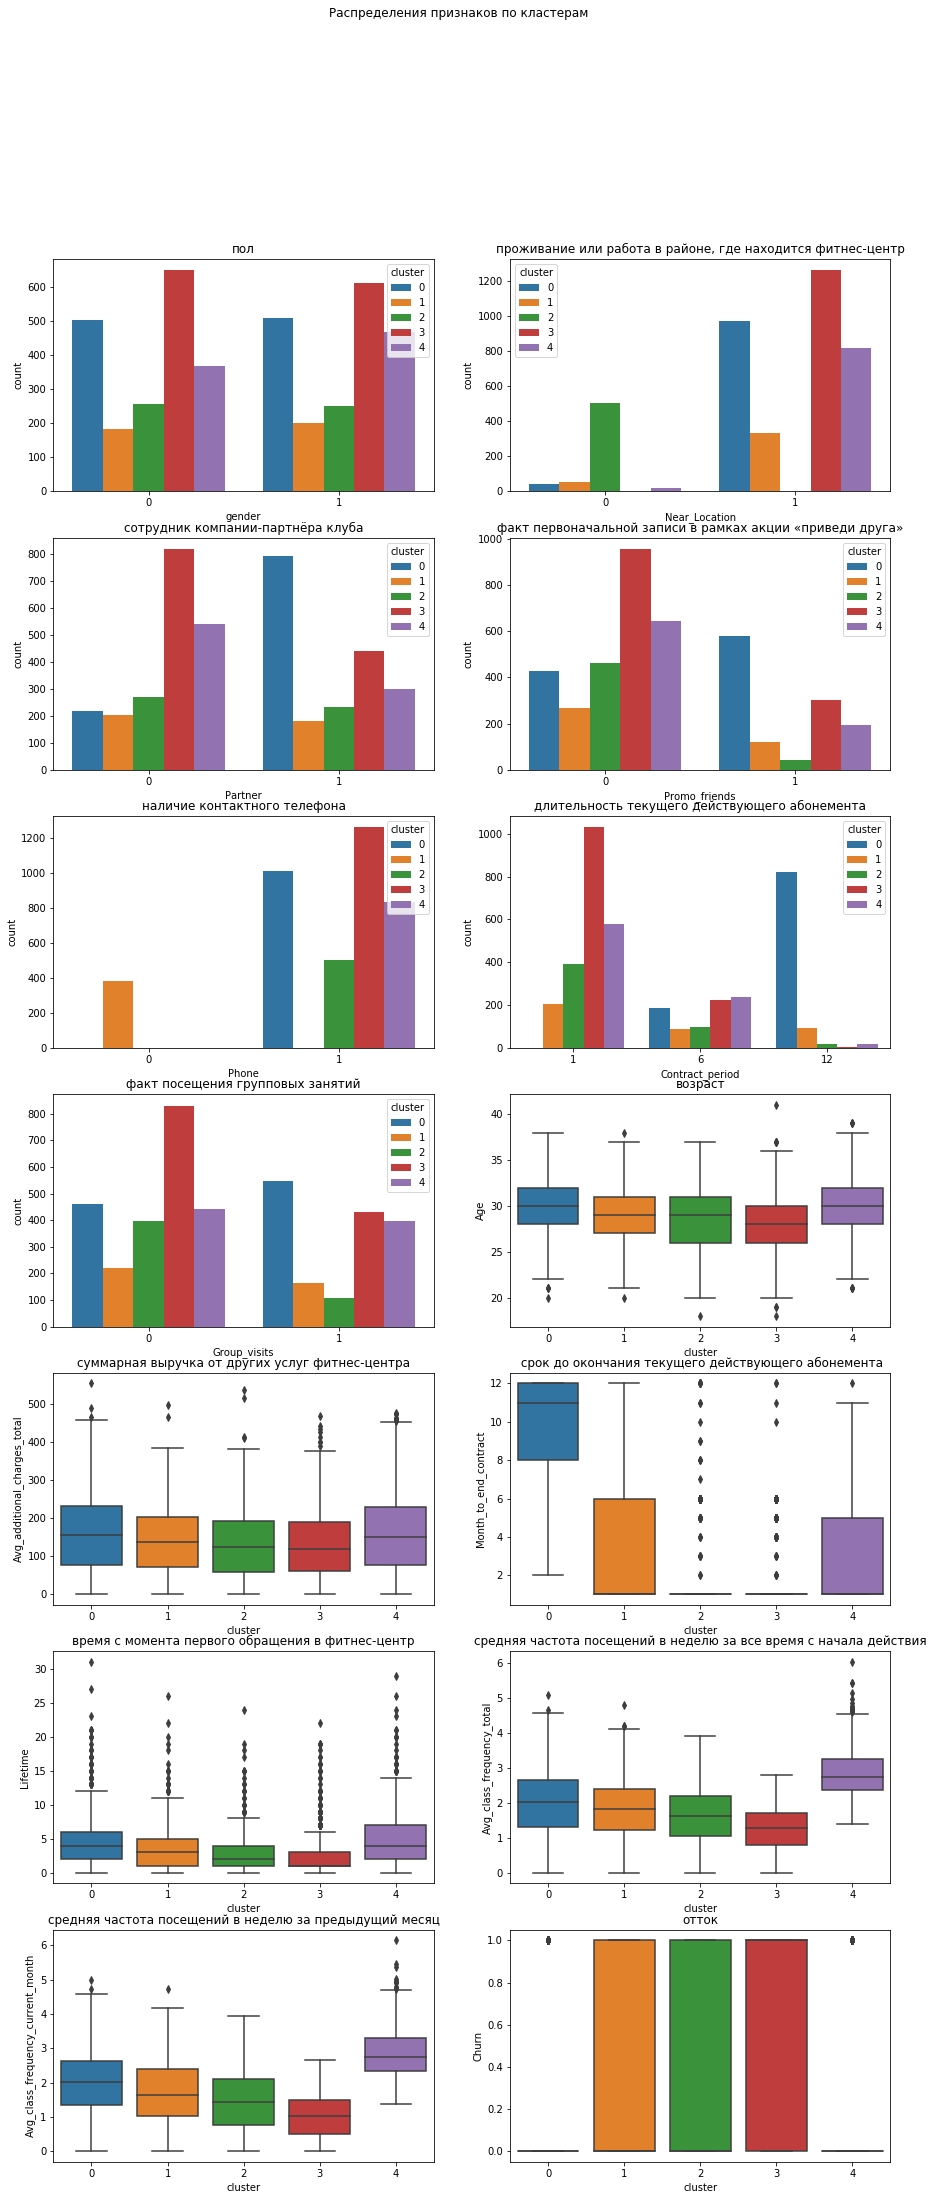

In [21]:
fig, axs = plt.subplots(7,2)
fig.suptitle('Распределения признаков по кластерам')
fig.set_figheight(35)
fig.set_figwidth(15)
sns.countplot(ax=axs[0][0], data = data[['cluster','gender']], x = 'gender', hue = 'cluster')
axs[0][0].set_title('пол')

sns.countplot(ax=axs[0][1], data = data[['cluster','Near_Location']], x = 'Near_Location', hue = 'cluster')
axs[0][1].set_title('проживание или работа в районе, где находится фитнес-центр')

sns.countplot(ax=axs[1][0], data = data[['cluster','Partner']], x = 'Partner', hue = 'cluster')
axs[1][0].set_title('сотрудник компании-партнёра клуба')

sns.countplot(ax=axs[1][1], data = data[['cluster','Promo_friends']], x = 'Promo_friends', hue = 'cluster')
axs[1][1].set_title('факт первоначальной записи в рамках акции «приведи друга»')

sns.countplot(ax=axs[2][0], data = data[['cluster','Phone']], x = 'Phone', hue = 'cluster')
axs[2][0].set_title('наличие контактного телефона')

sns.countplot(ax=axs[2][1], data = data[['cluster','Contract_period']], x = 'Contract_period', hue = 'cluster')
axs[2][1].set_title('длительность текущего действующего абонемента')

sns.countplot(ax=axs[3][0], data = data[['cluster','Group_visits']], x = 'Group_visits', hue = 'cluster')
axs[3][0].set_title('факт посещения групповых занятий')

sns.boxplot(ax=axs[3][1], x ='cluster',y = 'Age', data = data[['cluster','Age']])
axs[3][1].set_title('возраст')

sns.boxplot(ax=axs[4][0], x ='cluster',y = 'Avg_additional_charges_total', 
            data = data[['cluster','Avg_additional_charges_total']])
axs[4][0].set_title('суммарная выручка от других услуг фитнес-центра')

sns.boxplot(ax=axs[4][1], x ='cluster',y = 'Month_to_end_contract', data = data[['cluster','Month_to_end_contract']])
axs[4][1].set_title(' срок до окончания текущего действующего абонемента')

sns.boxplot(ax=axs[5][0], x ='cluster',y = 'Lifetime', data = data[['cluster','Lifetime']])
axs[5][0].set_title('время с момента первого обращения в фитнес-центр')

sns.boxplot(ax=axs[5][1], x ='cluster',y = 'Avg_class_frequency_total', 
            data = data[['cluster','Avg_class_frequency_total']])
axs[5][1].set_title('средняя частота посещений в неделю за все время с начала действия')

sns.boxplot(ax=axs[6][0], x ='cluster',y = 'Avg_class_frequency_current_month', 
            data = data[['cluster','Avg_class_frequency_current_month']])
axs[6][0].set_title('средняя частота посещений в неделю за предыдущий месяц')

sns.boxplot(ax=axs[6][1], x ='cluster',y = 'Churn', data = data[['cluster','Churn']])
axs[6][1].set_title('отток')

По графикам мы можем подтвердить наши наблюдения:
* Группа 0 живет/работает в районе фитнес-центра, является сотрудником компании-партнера, берет сразу длительные абонементы и достаточно хорошо ходит на тренировки (второй результат по всем группам)
* Группа 4 - энтузиасты спортзала. Они живут неподалеку и очень любят заниматься (лидируют со значительным отрывом среди всех групп).
* Группа 1 - среднячки, но без контактного телефона. Наверное, не любят узнавать новости от своего фитнес клуба.
* Группа 2 - не живут и не работают в районе клуба, приходят по акции "приведи друга" и берут короткие абонементы. На тренировки почти не ходят.
* Группа 3 - наихудшая. Хоть и живут рядом, но почти не ходят на тренировки. А зачем платить за абонемент, если ты им не пользуешься?

# Вывод

[*Назад к оглавлению*](#content)

<a id='finish'></a>

По общим данным мы можем сделать следующие выводы:
* по полу выборка достаточно равномерная: мужчины и женщины распределились почти в равных долях
* большинство (85%) клиентов живут или работают в локаци, где находится фитнес-клуб
* около половины клиентов - сотрудники компаний-партнеров клуба
* около 31% клиентов привели их друзья
* большинство клиентов (90%) оставили свой номер телефона
* 41% клиентов посещают групповые занятия
* средний и медианный возраст - 29 лет, стандартное отклонение всего 3,25 - так что разброс возраста не очень большой.
* в среднем клиенты тратят на другие услуги клуба около 150, однако стандартное отклонение состоявляет почти 100 - это очень большое разброс в данных. Кто-то из клиентов потратил более 550
* Больше половины клиентов заключили контракт на 1 месяц, остальные и по четверти клиентов контракты на 6 и 12 месяцев
* Также можно заметить, что у большинства клиентов до конца контрактв остались 1, 5-6 или 11-12 месяцев. Значит в основная часть клиентов совсем недавно заключали свои контракты.
* Это подтверждает и среднее время с момента первого обращения в фитнес-центр - для большинства клиентов это срок до 5 месяцев.
* Отток составляет около 26,5%.

В разбивке на оставшихся клиентов и отток ясно следующее:
* Мужчины и женщины уходят в отток одинакого - структура практически не поменялась
* Те, кто остаются в клубе, в основном живут в локации клуба (87%). Среди тех, кто уходит в отток таких всего 77%.
* Большая часть тех, кто остается в клубе являются сотрудниками компаний-партнеров. Из тех, кто ушел в отток, таких только 35%.
* Продолжающие заниматься куда чаще ходят на групповые тренировки - 46% против 27%.
* Подавляющее число клиентов попавших в отток брали контракт всего на один месяц, видимо, попробовали и им не понравилось. По продолжающим заниматься ситуация намного лучше, контрактов на 1 месяц все-таки большинство, но 12 месяцев не сильно отстают. Да и желающих заниматься полгода достаточно.
* Зато можно заметить, что в основном уходят люди слегка не доходя первый месяц. Те, кто остаются, в среднем имеют более длительные отношения с фитнес-центром - около 4,7 месяцев.
* Частота посещения клуба за все время примерно похожа для тех, кто уходит, и тех, кто остается (хотя в среднем те, кто остаются заниматься все же ходят почаще).
* А вот ситуация в последний месяц резко отличается: те, кто планирует уходить, почти не посещают клуб.

Для маркетингового отдела можно сделать следующие рекомендации:
* Делать упор на групповые тренировки. Те, кто на них ходит, куда реже уходят из клуба.
* Продолжать работу с акцией "приведи друга". Скорее всего заниматься со своими друзьями куда приятней (к тому же, вы можете стимулировать друг друга)
* Возможно стоит предлагать клиентам сразу более длинные контракты - так не будет искушения перестать ходить после одного месяца тренировок.
* Стоит рассмотреть группу потенциальных клиентов в близлежайшей к фитнес-центру локации. Может быть предложить акции при переходе из других ближайших клубов.
* Но не стоит забывать о клиентах, работающих в компаниях-партнерах, они достаточно охотно ходят на тренировки.